# Exploring Kinematic Equations Using Bayesian Inference

## Introduction
In this exercise, we use the Bayesian inference tool `bayesim` to perform a fit - in this case, fitting the trajectory of a rubber ball bouncing on the ground. We explore fitting the data of position vs. time using different models — and explore how a machine can derive equations of motion just by watching a bouncing ball.

The overall procedure is:
1. Define parameters to be fit (starting on a 20 x 20 grid) and initialize a uniform prior probability distribution
2. Generate the "observed" data and import it (there will be 59 different observation conditions)
3. Generate the modeled data to compare to observations - this will be done at every set of experimental conditions that were observed and at every point in the space defined by the fitting parameters (20 x 20 x 59 model computations)
4. Use Bayesian inference to compute the posterior probability distribution over the fitting parameters.
5. Choose a region of the fitting parameter space exceeding some threshold probability density and resample this region more densely (subdivide each grid box), discarding points outside the region.
6. Compute the new modeled data over this new fitting parameter space.
7. Repeat steps 4-6 until desired fit precision is reached.

## How to use this notebook
In many of the code cells, I've included commented-out lines representing alternative options to try. I suggest you step through the whole notebook once (evaluate each cell using <kbd>Shift</kbd>+<kbd>Enter</kbd>) without changing these to understand what's going on, then go back to the beginning and start tweaking them to see how the different options impact the progress and results of the fitting process.

## The data

The trajectory of a ball bouncing vertically and elastically off a rigid surface can be described by a series of (y, t) coordinates, i.e., the vertical position versus time. The purpose of this exercise is to derive the functional relationship between "y" and "t."

In [1]:
# import some code that we'll need
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. List the parameters
First, we list our fitting parameters, specifying their names, ranges of values, spacing, lengths, and units.

In [31]:
pl = byp.Param_list()
pl.add_fit_param(name='B', display_name="B", val_range=[1,20], length=20, units='arb.')
pl.add_fit_param(name='A', val_range=[1,20], length=20, min_width=0.01) # units default to "unitless"

# --------- alternative options --------
# try different val_range or length or play with min_width to see what it does with subdivisions later

Finally, we define the experimental conditions (EC's for short) and output variable. We use capital "T" to denote time.

In [32]:

pl.add_ec(name='T', units='second', is_x=True)
pl.add_output(name='S', units='m')

## Initialize the model
Now we're ready to initialize our bayesim Model object.

In [33]:
m = bym.Model(params=pl)

By default, a uniform probability distribution is created...

In [34]:
m.probs.points.head(10) # head(10) just shows the first ten lines in the DataFrame

,B,B_min,B_max,A,A_min,A_max,prob
0,1.475,1.0,1.95,1.475,1.00,1.95,0.0025
1,1.475,1.0,1.95,2.425,1.95,2.90,0.0025
2,1.475,1.0,1.95,3.375,2.90,3.85,0.0025
3,1.475,1.0,1.95,4.325,3.85,4.80,0.0025
4,1.475,1.0,1.95,5.275,4.80,5.75,0.0025
5,1.475,1.0,1.95,6.225,5.75,6.70,0.0025
6,1.475,1.0,1.95,7.175,6.70,7.65,0.0025
7,1.475,1.0,1.95,8.125,7.65,8.60,0.0025
8,1.475,1.0,1.95,9.075,8.60,9.55,0.0025
9,1.475,1.0,1.95,10.025,9.55,10.50,0.0025


Those `min` and `max` values are describing the edges of the grid boxes, and the parameter values are the centers.

## 2. Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $A=10$ and $B =9.8$ as our "true" parameters.

Here we generate and save the synthetic data as well as plot it.

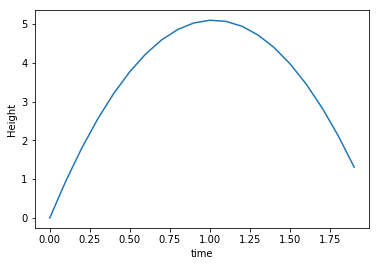

In [35]:
# implement the diode model in a function we can call
def compute_ID(ec,params):
    
    
    T = ec['T']
    
    A = params['A']
    B = params['B']
    S = max(0,A*T**1-1/2*B*T**2)
    return  S
def poly(ec,params):
    
    
    T = ec['T']
    
    A = params['A']
    B = params['B']
    S = max(0,A*T**1-1/2*B*T**2)
    return  S
def exp(ec,params):
    
    
    T = ec['T']
    
    A = params['A']
    B = params['B']
    S = max(0,A*math.exp(B*T))
    return  S
def sin(ec,params):
    
    
    T = ec['T']
    
    A = params['A']
    B = params['B']
    S = max(0,A*math.sin(B*T))
    return  S


# define the vectors of experimental conditions
T = np.arange(0,2.0,0.1)


# set the "true" values for the parameters
params = {'A':10,'B':9.8}

# generate the "observations"
data = []
for t in T:
    S = compute_ID({'T':t},params)
    if abs(S)>0.1:
        err = 1e-3*abs(S)
    else:
        err = 1e-3

    data.append([t,S,err])

# save them to HDF5
data = pd.DataFrame.from_records(data=data,columns=['T','S','uncertainty'])
dd.io.save('obs_data.h5',data)

# these next few lines are for generating the plot
leg = []
plt.plot(data['T'],data['S'])

plt.xlabel('time')
plt.ylabel('Height')
plt.show()

Let's see how many data points we generated.

In [36]:
len(data)

20

Now that we've generated our "observations," we can attach them to `bayesim`. There are some options when we attach the observations, notably `keep_all` and `max_ec_x_step`. If `keep_all` is set to False, `attach_observations` will only import data points that differ from each other by more than 1% of the full y-axis range (this 1% threshold can be modified with the `thresh_dif_frac` option) in the output variable (J) along the defined x-axis variable (V). However, `max_ec_x_step` tells it to only skip a maximum of 0.2 V before saving a point even if it differs by $<1$% from the previous one.

This allows us to sample more densely in regions where the output variable is changing rapidly and save simulation load in regions where it changes more slowly.

Finally, we define the experimental uncertainty. We could define custom uncertainty values at each measurement point by including an 'uncertainty' column in the file with the observed data. If you would rather use a fixed value of experimental uncertainty for all measurements, use the `fixed_unc` keyword as we do here.

In [37]:
m.attach_observations(obs_data_path='obs_data.h5',  fixed_unc=1e-3)

# ---------- alternative options ------------

# don't discard any data
#m.attach_observations(obs_data_path='obs_data.h5', fixed_unc=0.0001)

# changing max_ec_x_step
#m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.1, fixed_unc=0.0001)

# changing thresh_dif_frac
#m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.1, thresh_dif_frac=0.001, fixed_unc=0.0001)

# using uncertainty values from file rather than fixed value
#m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.2)

## 3. Attach modeled data
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [39]:
m.attach_model(mode='function', model_data_func=poly)

# how to attach from a file instead
#m.attach_model(mode='file',fpath='model_data.h5')

Rounding model data...


When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [40]:
m.model_data.head()

,B,A,T,S
0,1.475,1.475,0.0,0.000000
1,1.475,1.475,0.1,0.140125
2,1.475,1.475,0.2,0.265500
3,1.475,1.475,0.3,0.376125
4,1.475,1.475,0.4,0.472000


We'll also compute the "model uncertainty" - the difference in output variable (at a fixed set of experimental conditions) when one moves around the fitting parameter space. For each point, the likelihood will be calculated with a standard deviation equal to the maximum of the experimental uncertainty and the model uncertainty.

In [41]:
m.calc_model_unc()

In [42]:
m.model_data.sample(5)

,B,A,T,S,uncertainty
7612,19.525,1.475,1.2,0.000000,0.0000
3420,9.075,11.925,0.0,0.000000,0.0000
2969,8.125,9.075,0.9,4.876875,0.4275
7094,17.625,14.775,1.4,3.412500,0.6650
5381,13.825,10.025,0.1,0.933375,0.0475


## 4. Drop that Bayes!
We're ready to do our Bayesian inference! The `run` function has many options we can set but can also be called with no arguments to run in the default way. In this case, the default is:

A threshold probability concentration is defined by an amount of probability mass (`th_pm`, defaults to 0.8) and a fraction of the fitting parameter space volume (`th_pv`, defaults to 0.05). `bayesim` chooses observation points randomly (without replacement) for Bayesian updates until at least `th_pm` of the probability resides in at most `th_pv` of the parameter space.

However, depending on the thresholds set, data sampling and other factors, this threshold could potentially take very few observation points to reach, meaning we will inevitably be sampling our experimental conditions unevenly. To address this, a parameter `min_num_pts` is defined (with a default value of 0.7 * the number of observed data points). The procedure just described is repeated until that number of points has been used, and the resulting probability distributions from each cycle are averaged together to produce the final result.

In [43]:
m.run()

# ------- alternative options ------

# different thresholding conditions
#m.run(th_pm=0.9, th_pv=0.02)

# use all the observed data
#m.run(min_num_pts=len(m.obs_data))

Did a total of 12 runs to use a total of 14 observations.


An average of 292 / 400 probability points had larger model uncertainty than experimental uncertainty during this run.


An average of 0.00 / 400 probability points were affected by missing/NaN simulation data.



We can visualize the distribution and add markers for the real values to compare...

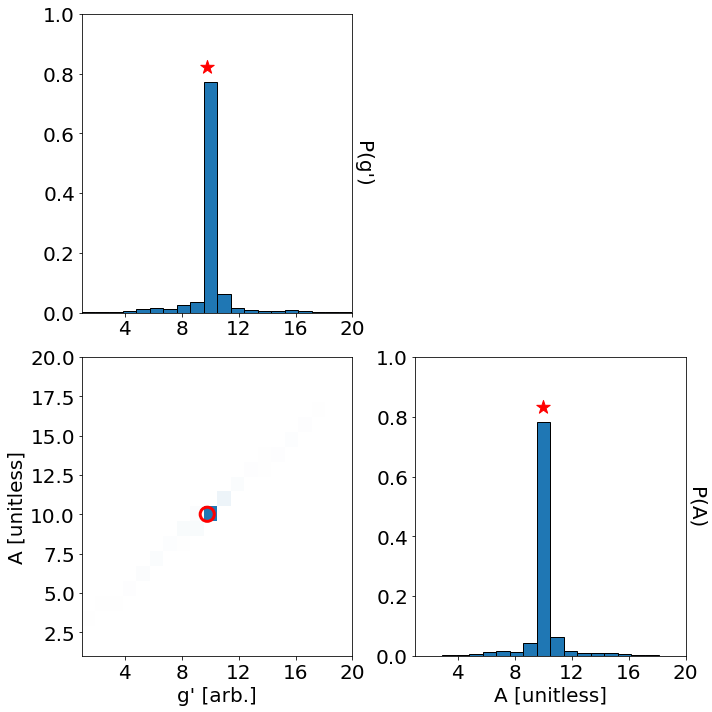

In [44]:
m.visualize_probs(true_vals=params)

We can also plot the simulated data corresponding to the most probable points (in this case, three of them) in parameter space and compare to the observed data at the same conditions.

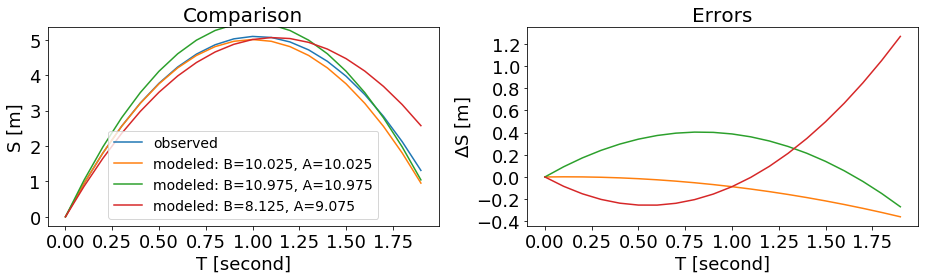

In [51]:
m.comparison_plot(num_param_pts=3)

Not too bad. We can also of course look at the probabilities directly...

In [52]:
m.top_probs(5)

,prob,B,B_min,B_max,A,A_min,A_max
189,0.770692,10.025,9.55,10.50,10.025,9.55,10.50
210,0.061695,10.975,10.50,11.45,10.975,10.50,11.45
148,0.021122,8.125,7.65,8.60,9.075,8.60,9.55
168,0.021071,9.075,8.60,9.55,9.075,8.60,9.55
231,0.015570,11.925,11.45,12.40,11.925,11.45,12.40


In [53]:
params

{'A': 10, 'B': 9.8}

In [54]:
m.top_probs(1)

,prob,B,B_min,B_max,A,A_min,A_max
189,0.770692,10.025,9.55,10.5,10.025,9.55,10.5


In [58]:
B_err = abs((params['A']-m.top_probs(1)['B'].iloc[0])/params['B'])
A_err = abs((params['B']-m.top_probs(1)['A'].iloc[0])/params['A'])
print("Error in B determination: %.2f%% \nError in A determination: %.2f%%"%(100*B_err, 100*A_err))

Error in B determination: 0.26% 
Error in A determination: 2.25%


Not too shabby, I'd say.